In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../vision_fit'))  # insert parent path
import time
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import scipy
import pickle as pkl
import h5py
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import style
from imagenet_classes import lab_dict
import sklearn
import pandas as pd
import stats

%load_ext autoreload
%autoreload 2

In [2]:
style.set_style()
import warnings
warnings.filterwarnings("ignore")

# get data on labs, preds, and feats

In [44]:
out_dir = '/accounts/projects/vision/scratch/yu_dl/raaz.rsk/cnns_preds'
fnames = sorted(os.listdir(out_dir))
print(fnames)

# labs_train slightly smaller because part of last batch gets cut off
labs_train = np.array(h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_train'])
labs_val = np.array(h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_val'])

preds_train = h5py.File(oj(out_dir, 'alexnet.h5'), 'r')['preds_train']
preds_val = h5py.File(oj(out_dir, 'densenet169.h5'), 'r')['preds_val']

feats_train = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_train']
feats_val = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_val']

['alexnet.h5', 'alexnet_corrs.h5', 'alexnet_feats.h5', 'densenet169.h5', 'densenet169_corrs.h5', 'ind_tops_train.pkl', 'ind_tops_val.pkl', 'labs.h5', 'resnet18.h5', 'resnet18_corrs.h5', 'resnet50.h5', 'vgg11.h5', 'vgg11_corrs.h5', 'vgg13.h5', 'vgg13_corrs.h5', 'vgg16.h5', 'vgg19.h5']


# pairwise pred plots

mean: 0.65, [0.8431166909614919, 0.840097846091936, 0.7155312751603533, 0.673810948664757, 0.5596489991216772, 0.6599716554930394, 0.7514585257933221, 0.4732741840483416, 0.5005053597969736, 0.5279050558430235]


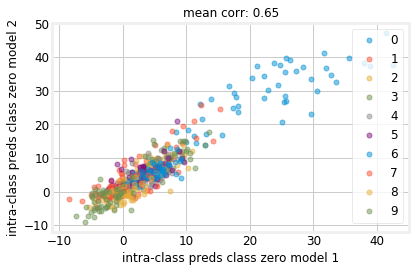

In [64]:
# ['alexnet.h5', 'alexnet_feats.h5', 'densenet169.h5', 'labs.h5', 'resnet18.h5', 
# 'resnet50.h5', 'top_10_inds_dict.pkl', 'vgg11.h5', 'vgg13.h5', 'vgg16.h5', 'vgg19.h5']
p1 = np.array(h5py.File(oj(out_dir, 'alexnet.h5'), 'r')['preds_val'])
p2 = np.array(h5py.File(oj(out_dir, 'vgg11.h5'), 'r')['preds_val'])

for lab_num in range(10):
    plt.plot(p1[labs_val==lab_num][:, 0], 
             p2[labs_val==lab_num][:, 0], '.', alpha=0.5, label=str(lab_num))
plt.legend()
plt.xlabel('intra-class preds class zero model 1')
plt.ylabel('intra-class preds class zero model 2')
corrs = []
for lab_num in range(10):
    corrs.append(np.corrcoef(p1[labs_val==lab_num][:, 0], p2[labs_val==lab_num][:, 0])[0, 1])
print(f'mean: {np.mean(corrs):.2f}, {corrs}')
plt.title(f'mean corr: {np.mean(corrs):.2f}')
plt.tight_layout()
plt.savefig('imagenet_intra_class_preds_class=0.png', dpi=300)

mean: 0.71, [0.8218758393844797, 0.7498030230372421, 0.7167978155486561, 0.6255460842416168, 0.36764233551045594, 0.8680667679882752, 0.8144059235220529, 0.7043089636523435, 0.7538610381867796, 0.6880315451771803]


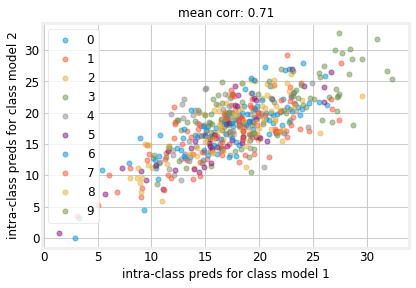

In [34]:
# ['alexnet.h5', 'alexnet_feats.h5', 'densenet169.h5', 'labs.h5', 'resnet18.h5', 
# 'resnet50.h5', 'top_10_inds_dict.pkl', 'vgg11.h5', 'vgg13.h5', 'vgg16.h5', 'vgg19.h5']
p1 = np.array(h5py.File(oj(out_dir, 'densenet169.h5'), 'r')['preds_val'])
p2 = np.array(h5py.File(oj(out_dir, 'resnet50.h5'), 'r')['preds_val'])

for lab_num in range(10):
    plt.plot(p1[labs_val==lab_num][:, lab_num], 
             p2[labs_val==lab_num][:, lab_num], '.', alpha=0.5, label=str(lab_num))
plt.legend()
plt.xlabel('intra-class preds for class model 1')
plt.ylabel('intra-class preds for class model 2')
corrs = []
for lab_num in range(10):
    corrs.append(np.corrcoef(p1[labs_val==lab_num][:, lab_num], p2[labs_val==lab_num][:, lab_num])[0, 1])
print(f'mean: {np.mean(corrs):.2f}, {corrs}')
plt.tight_layout()
plt.title(f'mean corr: {np.mean(corrs):.2f}')
plt.savefig('imagenet_intra_class_preds.png', dpi=300)

**correlations persist after softmax**

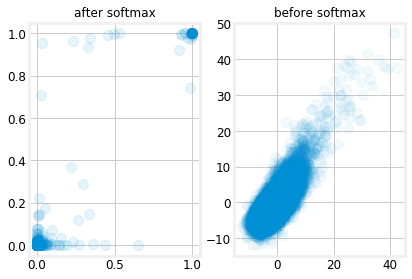

In [67]:
plt.subplot(121)
plt.title('after softmax')
plt.plot(scipy.special.softmax(p1, axis=1)[:, 0], 
         scipy.special.softmax(p2, axis=1)[:, 0], 'o', alpha=0.1)

plt.subplot(122)
plt.title('before softmax')
plt.plot(p1[:, 0], p2[:, 0], 'o', alpha=0.05)
plt.show()

# calc all pairwise corrs

In [87]:
def calc_corrs(p1, p2, labs):
    p1_max = np.argmax(p1, axis=1)
    p2_max = np.argmax(p2, axis=1)
    idxs_both_correct = (p1_max == labs) * (p2_max == labs)

    # try with softmax also

    # raw correlation
    raw_corr = stats.corr(p1.flatten(), p2.flatten())
#     print(f'raw corr: {raw_corr: 0.5f}')

    # correlation within each class for all columns
    class_corrs = np.zeros(1000)
    for lab_num in range(1000):
        idxs = labs == lab_num
        class_corrs[lab_num] = stats.corr(p1[idxs].flatten(), p2[idxs].flatten())
    intra_class_corr_all = np.mean(class_corrs)
#     print(f'intra-class corr all columns: {intra_class_corr_all: 0.5f}')

    # correlation within each class for just correct column
    '''
    class_corrs = np.zeros(1000)
    for lab_num in range(1000):
        idxs = labs == lab_num
        class_corrs[lab_num] = stats.corr(p1[idxs][:, lab_num], p2[idxs][:, lab_num])
    intra_class_corr_column = np.mean(class_corrs)    
    print(f'\tintra-class corr class-column: {np.mean(intra_class_corr_correct): 0.5f}')
    '''

    # correlation when both networks correct
    class_corrs = np.zeros(1000)
    for lab_num in range(1000):
        idxs = (labs == lab_num) * (idxs_both_correct)
        class_corrs[lab_num] = stats.corr(p1[idxs].flatten(), p2[idxs].flatten())
    intra_class_corr_correct = np.mean(class_corrs)
#     print(f'intra-class corr for correct points: {intra_class_corr_correct: 0.5f}')
    
    return {'raw_corr': raw_corr, 'intra_class_corr_all': intra_class_corr_all, 'intra_class_corr_correct': intra_class_corr_correct}

In [ ]:
nets = ['alexnet', 'vgg11', 'vgg13', 'resnet18', 'densenet169']
dset = 'train' # ['val', 'train']
softmax = False # [False, True]
corrs_dict = {'raw_corr': np.zeros((len(nets), len(nets))), 
              'intra_class_corr_all': np.zeros((len(nets), len(nets))), 
              'intra_class_corr_correct': np.zeros((len(nets), len(nets)))}
for i, net1 in tqdm(enumerate(nets)):
    for j, net2 in enumerate(nets):
        labs = np.array(h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_' + dset])        
        p1 = np.array(h5py.File(oj(out_dir, net1 + '.h5'), 'r')['preds_' + dset])[:labs.size]
        p2 = np.array(h5py.File(oj(out_dir, net2 + '.h5'), 'r')['preds_' + dset])[:labs.size]


        if softmax:
            p1 = scipy.special.softmax(p1, axis=1)
            p2 = scipy.special.softmax(p2, axis=1)                
        
        corrs = calc_corrs(p1, p2, labs)
        for key in corrs:
            corrs_dict[key][i, j] = corrs[key]

In [161]:
# corr_comparisons_dict_val.pkl - val, no softmax
# corr_comparisons_dict_val_softmax.pkl - val, with softmax
# corr_comparisons_dict_train.pkl - train, no softmax
# pkl.dump(corrs_dict, open('corr_comparisons_dict_val_softmax.pkl', 'wb'))
# pkl.dump(corrs_dict, open('corr_comparisons_dict_train.pkl', 'wb'))

corrs_dict = pkl.load(open('corr_comparisons_dict_val.pkl', 'rb'))
# corrs_dict = pkl.load(open('corr_comparisons_dict_train.pkl', 'rb'))

In [ ]:
plt.figure(figsize=(16, 6))
tits = ['Raw', 'Intra-class', 'Intra-class both correct']
for i, corr_type in enumerate(['raw_corr', 'intra_class_corr_all', 'intra_class_corr_correct']):
    plt.subplot(1, 3, i + 1)
    sns.heatmap(corrs_dict[corr_type], annot=True, vmin=0.5, vmax=1, cbar=False, fmt='.3f')
#     plt.imshow(corrs_dict['raw_corr'])
#     plt.grid(False)
#     plt.clim(0, 1)

    plt.xticks(0.5 + np.arange(len(nets)), nets, rotation='vertical')

    plt.title(tits[i])
    plt.yticks([])
    if i == 0:
        plt.yticks(0.5 + np.arange(len(nets)),  nets, rotation='horizontal')
#     if i == 2:
#         plt.colorbar()

plt.tight_layout()
plt.savefig('pred_corrs_train_full.pdf')
plt.show()

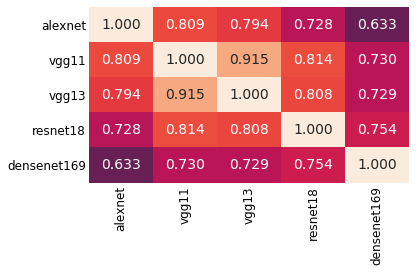

In [164]:
sns.heatmap(corrs_dict['intra_class_corr_correct'], annot=True, vmin=0.5, vmax=1, cbar=False, fmt='.3f')
plt.xticks(0.5 + np.arange(len(nets)), nets, rotation='vertical')
plt.yticks(0.5 + np.arange(len(nets)),  nets, rotation='horizontal')

plt.tight_layout()
plt.savefig('pred_corrs_val.pdf')
plt.show()

# do different nets put their maxes at the same place? -> **answer: yes**

In [ ]:
ind_tops = {} # these are in ascending order
for fname in tqdm(['alexnet.h5', 'vgg11.h5', 'vgg13.h5', 'resnet18.h5', 'densenet169.h5']):
#     preds = h5py.File(oj(out_dir, fname + corr), 'r')['preds_train']
    preds = h5py.File(oj(out_dir, fname[:-3] + '_corrs' + '.h5'), 'r')['corrs_train']    

    # get largest indices for each class
    ind_top = np.argsort(preds, axis=0) # in ascending order
    ind_tops[fname] = ind_top[-50:]
    
# pkl.dump(ind_tops, open(oj(out_dir, "ind_tops_train.pkl"), "wb" ))
pkl.dump(ind_tops, open(oj(out_dir, "ind_tops_train_corrs.pkl"), "wb" ))

In [59]:
ind_tops_val = pkl.load(open(oj(out_dir, "ind_tops_val_corrs.pkl"), "rb"))
ind_tops_train = pkl.load(open(oj(out_dir, "ind_tops_train_corrs.pkl"), "rb")) # contain 'alexnet.h5', 'vgg11.h5', 'vgg13.h5', 'vgg16.h5', 'resnet18.h5', 'densenet169.h5'

0.062 0.136 0.035 

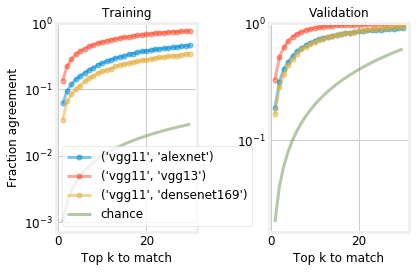

In [60]:
# note: need to pass in ks!
ks = np.arange(1, 31)

plt.subplot(121)
plt.title('Training')

nets_list = [('vgg11', 'alexnet'), ('vgg11', 'vgg13'), ('vgg11', 'densenet169')]
for nets in nets_list:
    nums_agree = []
    for k in ks:
        num1 = stats.num_agree_topk(ind_tops_train[nets[0] + '.h5'], ind_tops_train[nets[1] + '.h5'], k=k) / 1000.0
        num2 = stats.num_agree_topk(ind_tops_train[nets[1] + '.h5'], ind_tops_train[nets[0] + '.h5'], k=k) / 1000.0
        nums_agree.append((num1 + num2) / 2.0)
    plt.plot(ks, nums_agree, '.-', label=str(nets))
    print(nums_agree[0], end=' ')
plt.semilogy(ks, ks / 1000, '-', label='chance')
plt.xlabel('Top k to match')
plt.ylabel('Fraction agreement')
plt.ylim(0, 1)
plt.legend()

plt.subplot(122)
plt.title('Validation')

for nets in nets_list:
    nums_agree = []
    for k in ks:
        num1 = stats.num_agree_topk(ind_tops_val[nets[0] + '.h5'], ind_tops_val[nets[1] + '.h5'], k=k) / 1000
        num2 = stats.num_agree_topk(ind_tops_val[nets[1] + '.h5'], ind_tops_val[nets[0] + '.h5'], k=k) / 1000
        nums_agree.append((num1 + num2) / 2)
    plt.plot(ks, nums_agree, '.-', label=str(nets))
plt.semilogy(ks, ks / 50, '-', label='chance')
plt.ylim(0, 1)
plt.xlabel('Top k to match')
# plt.ylabel('Percent agreement')

plt.tight_layout()
plt.savefig('topk_corrs.pdf')
plt.show()